In [ ]:
# Installing PYDICOM
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import pylab as pl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pydicom as dcm
import math
from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence
import seaborn as sns
sns.set_style('darkgrid')
from tqdm import tqdm, tqdm_notebook
from skimage.transform import resize
from skimage import io, measure

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
# Step 1: Importing the data from drive location in google drive
folder_path = '/content/drive/MyDrive/CV_capstone/'
# Reading stage 2 Training label file from specified path
labels = pd.read_csv(folder_path + 'stage_2_train_labels.csv')

In [ ]:
print('\n First 5 rows of Training set :')
labels.head()


 First 5 rows of Training set :


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


**The dataset from train_labels.csv contain details about the patient-id and the co-ordinates of the bounding boxes along with the width and height & binary classification column as Target which indicate whether the sample image has traces of pneumonia or no. Indiacted with dataframe name "labels".**

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [ ]:
# number of enteries in the Labels dataframe
labels.shape

(30227, 6)

Labels dataframe has 30227 rows and 6 columns

In [ ]:
print('Number of unique patientId in the dataframe : {0}'.format(labels['patientId'].nunique()))

Number of unique patientId in the dataframe : 26684


Labels dataframe have 26684 unique patientids, some of them might have multiple entries in the dataset.

In [ ]:
print('No of entries which has Pneumonia : {0} '.format(labels[labels.Target == 1].shape[0], round(labels[labels.Target == 1].shape[0]/labels.shape[0]*100, 0)))
print('No of entries which don\'t have Pneumonia : {0} \n'.format(labels[labels.Target == 0].shape[0], round(labels[labels.Target == 0].shape[0]/labels.shape[0]*100, 0)))

No of entries which has Pneumonia : 9555 
No of entries which don't have Pneumonia : 20672 



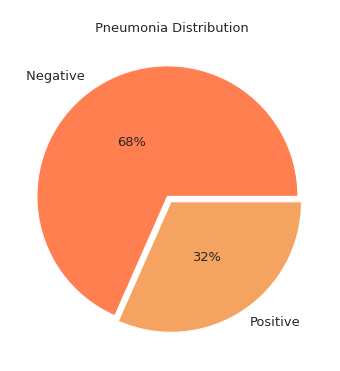

In [ ]:
colors = ['coral','sandybrown']

plt.figure(figsize=(10,6))
textprops = {'fontsize':13}  # Font size of text in pie chart
labels['Target'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', explode = [0.04,0.01], labels = [' Negative ', 'Positive'], startangle=0, pctdistance=0.5, labeldistance=1.1, textprops = textprops, colors= colors)
plt.title('\n Pneumonia Distribution', fontdict=textprops)
plt.xlabel('')
plt.ylabel('')
plt.show()

The dataset contains data 30,277 records of which there are 26,684 unique patients id's, Suggesting some patients have more than one entry, **i.e** more than one bounding boxes detecting pneumonia.

In [ ]:
# Reading stage 2 class info file from specified path
class_info = pd.read_csv(folder_path + 'stage_2_detailed_class_info.csv')
print('First 5 rows of Class info dataset are :')
class_info.head()

First 5 rows of Class info dataset are :


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


Data coresponding to 'patientId' to is divided into 3 labels: Normal,Lung opacity & Not normal / no lung opacity.

In [ ]:
# Number of entries in class_label dataframe
print('The class_labels dataframe has {0} rows and {1} columns.'.format(class_info.shape[0], class_info.shape[1]))

The class_labels dataframe has 30227 rows and 2 columns.


In [ ]:
# Number of unique patients in class info dataframe
print('Number of unique patientId are : {0}'.format(class_info['patientId'].nunique()))

Number of unique patientId are : 26684


The **class_info** dataset contains information about **26684** patients, which is same as that of the **labels** dataframe.

In [ ]:
# function to get count for each label

def feature_dist(dataf, feat):
    lblcounts = dataf[feat].value_counts()
    # Count the number of items in each class
    total_samples = len(dataf)
    print('Feature: {}'.format(feat))
    for i in range(len(lblcounts)):
        label = lblcounts.index[i]
        count = lblcounts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print('{0:<30s}: {1} which is {2}% of the total data in the dataset'.format(label, count, percent))

In [ ]:
feature_dist(class_info, 'class')

Feature: class
No Lung Opacity / Not Normal  : 11821 which is 39.1% of the total data in the dataset
Lung Opacity                  : 9555 which is 31.61% of the total data in the dataset
Normal                        : 8851 which is 29.28% of the total data in the dataset


Text(0, 0.5, '')

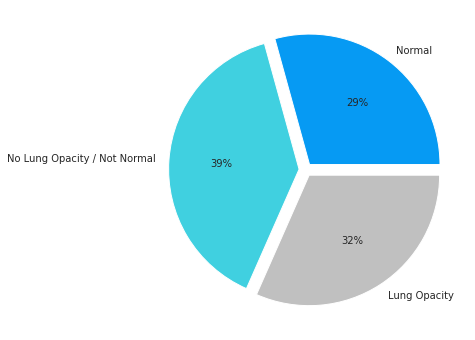

In [ ]:
colors = ['#069AF3','#40D0E0','#C0C0C0' ]

plt.figure(figsize=(10,6))
class_info['class'].value_counts().sort_index(ascending = False).plot(kind = 'pie', autopct = '%.0f%%', explode = [0.05,0.05,0.05], colors=colors).set_ylabel('')


In [ ]:
# Checking nulls in class_labels
print('Number of nulls in class columns : {0}'.format(class_info['class'].isnull().sum()))

Number of nulls in class columns : 0


In [ ]:
# Checking whether each patientId has only one type of class or not
class_info.groupby(['patientId'])['class'].nunique().max()

1

**labels & class_ info  datasets are combined to generate a single dataset to work upon**

In [ ]:
# Merging the two dataset - 'train_labels' and 'class_labels'
td1 = pd.concat([labels, class_info['class']], axis = 1)
print('After merging, the dataset looks like : ')
td1.head()

After merging, the dataset looks like : 


,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


Text(0.5, 1.0, 'Class and Target  Distrubution')

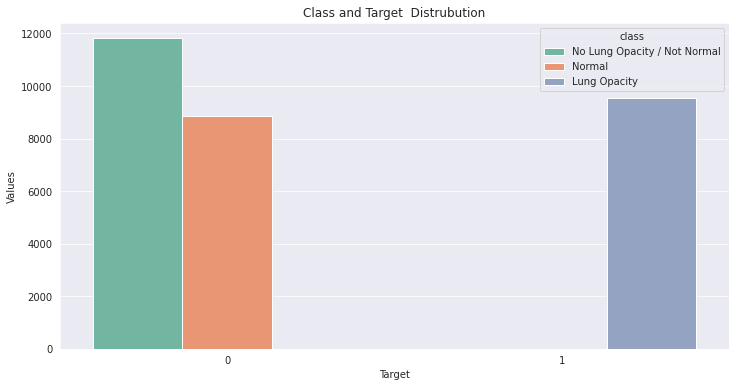

In [ ]:
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = td1.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class, palette = 'Set2')
plt.title('Class and Target  Distrubution')

**Target = 1 is associated with only class = Lung Opacity whereas Target = 0 is associated with classes = No Lung Opacity / Not Normal as well as Normal.**

Bounding Box Distribution

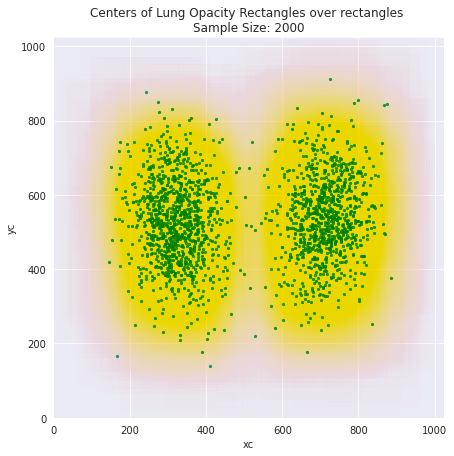

In [ ]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1, 1, figsize = (7, 7))
target_1 = td1[td1['Target'] == 1]
target_sample = target_1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title('Centers of Lung Opacity Rectangles over rectangles \nSample Size: 2000')
target_sample.plot.scatter(x = 'xc', y = 'yc', xlim = (0, 1024), ylim = (0, 1024), ax = ax, alpha = 0.8, marker = '.', color = '#008080')

for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="#FFD700"))

Centers of bounding box are spread out evenly across the Lungs. Though a large portion of the bounding box have their centers at the centers of the Lung, but some centers of the box are also located at the edges.

**Extracting stage_2_train_images & stage_2_test_images from zip folder**

In [ ]:
from zipfile import ZipFile

train_file_path = '/content/drive/MyDrive/CV_capstone/stage_2_train_images.zip'
test_file_path = '/content/drive/MyDrive/CV_capstone/stage_2_test_images.zip'

with ZipFile(train_file_path, 'r') as z:
  z.extractall()

with ZipFile(test_file_path, 'r') as a:
  a.extractall()

In [ ]:
sample_patientId = td1['patientId'][0]
dcm_file = '/content/stage_2_train_images/'+'{}.dcm'.format(sample_patientId)
dcm_data = dcm.read_file(dcm_file)

print('Metadata of the image consists of : \n\n', dcm_data)

Metadata of the image consists of : 

 Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '

In [ ]:
train_imag_path = '/content/stage_2_train_images/'

In [ ]:
print('Number of images in training images folders are : {0}'.format(len(os.listdir(train_imag_path))))

Number of images in training images folders are : 26685


We can see that in the training images folder we have just 26684 images which is same as that of unique patientId's present in either of the csv files. Thus, each of the unique patientId's present in either of the csv files correlates to an image present in the folder.

In [ ]:
images = pd.DataFrame({'path': glob(os.path.join(train_imag_path, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x:os.path.splitext(os.path.basename(x))[0])
print('Columns in the training images dataframe : {0}'.format(list(images.columns)))

Columns in the training images dataframe : ['path', 'patientId']


In [ ]:
# Merging the images dataframe with td1 dataframe
training_data = td1.merge(images, on = 'patientId', how = 'left')
print('Post Merge operation., the training_data has {0} rows and {1} columns.'.format(training_data.shape[0], training_data.shape[1]))


Post Merge operation., the training_data has 30227 rows and 8 columns.


In [ ]:
print('The training_data dataframe :')

training_data.head()

The training_data dataframe :


,patientId,x,y,width,height,Target,class,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/stage_2_train_images/0004cfab-14fd-4e...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/stage_2_train_images/00313ee0-9eaa-42...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/stage_2_train_images/00322d4d-1c29-49...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,/content/stage_2_train_images/003d8fa0-6bf1-40...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,/content/stage_2_train_images/00436515-870c-4b...


In [ ]:
columns_to_add = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def parsedicomdata(data_df, data_path):
    for col in columns_to_add:
        data_df[col] = None
    image_names = os.listdir('stage_2_train_images/')

    for i, img_name in tqdm_notebook(enumerate(image_names)):
        imagepath = os.path.join('stage_2_train_images/', img_name)
        data_img = dcm.read_file(imagepath)
        idx = (data_df['patientId'] == data_img.PatientID)
        data_df.loc[idx, 'Modality'] = data_img.Modality
        data_df.loc[idx, 'PatientAge'] = pd.to_numeric(data_img.PatientAge)
        data_df.loc[idx, 'PatientSex'] = data_img.PatientSex
        data_df.loc[idx, 'BodyPartExamined'] = data_img.BodyPartExamined
        data_df.loc[idx, 'ViewPosition'] = data_img.ViewPosition
        data_df.loc[idx, 'ConversionType'] = data_img.ConversionType
        data_df.loc[idx, 'Rows'] = data_img.Rows
        data_df.loc[idx, 'Columns'] = data_img.Columns
        data_df.loc[idx, 'PixelSpacing'] = str.format("{:4.3f}", data_img.PixelSpacing[0])

In [ ]:
parsedicomdata(training_data, '/content/stage_2_train_images/')


0it [00:00, ?it/s]

InvalidDicomError: ignored

In [ ]:
print('Parsing the information from the dicom images, our training_data dataframe has {0} rows and {1} columns and it looks like, \n'.format(training_data.shape[0], training_data.shape[1]))
training_data.head()

In [ ]:
# Saving the training_data for further use
training_data.to_pickle('trainingdata_pickle.pkl')

*** EDA ***

In [ ]:
tdpk1 = pd.read_pickle('trainingdata_pickle.pkl')

tdpk1.head()

,patientId,x,y,width,height,Target,class,path,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/stage_2_train_images/0004cfab-14fd-4e...,CR,51,F,CHEST,PA,WSD,1024,1024,0.143
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/stage_2_train_images/00313ee0-9eaa-42...,CR,48,F,CHEST,PA,WSD,1024,1024,0.194
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/stage_2_train_images/00322d4d-1c29-49...,CR,19,M,CHEST,AP,WSD,1024,1024,0.168
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,/content/stage_2_train_images/003d8fa0-6bf1-40...,CR,28,M,CHEST,PA,WSD,1024,1024,0.143
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,/content/stage_2_train_images/00436515-870c-4b...,CR,32,F,CHEST,AP,WSD,1024,1024,0.139


In [ ]:
# Checking body part Examined
feature_dist(tdpk1, 'BodyPartExamined')

Feature: BodyPartExamined
CHEST                         : 30227 which is 100.0% of the total data in the dataset


In [ ]:
# Modality
feature_dist(tdpk1, 'Modality')

Feature: Modality
CR                            : 30227 which is 100.0% of the total data in the dataset


In [ ]:
# View position
feature_dist(tdpk1, 'ViewPosition')

Feature: ViewPosition
AP                            : 15297 which is 50.6% of the total data in the dataset
PA                            : 14930 which is 49.39% of the total data in the dataset


AP : 15297 which is 50.6% of the total data in the dataset

PA : 14930 which is 49.39% of the total data in the dataset

X-rays are mostly obtained from the front-view. A lateral image is also usually taken to complement the front-view.

Posterior/Anterior (PA): Here the chest radiograph is acquired by passing the X-Ray beam from the patient's posterior (back) part of the chest to the anterior (front) part. While obtaining the image patient is asked to stand with their chest against the film. In this image, the heart is on the right side of the image from one's perspective.
Anterior/Posterior (AP): At times it is not possible for radiographers to acquire a PA chest X-ray. This is usually because the patient is too unwell to stand. In these images the size of heart looks large.

The distribution of View Position when there is an evidence of Pneumonia :



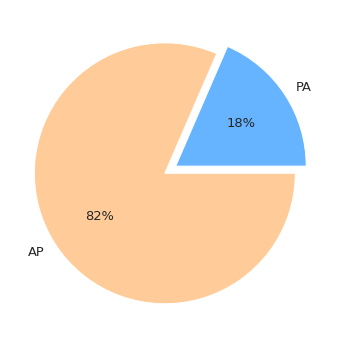

In [ ]:
colors = ['#66b3ff','#ffcc99']
print('The distribution of View Position when there is an evidence of Pneumonia :\n')
plt.figure(figsize=(10,6))
tdpk1.loc[training_data['Target'] == 1, 'ViewPosition'].value_counts().sort_index(ascending = False).plot(kind = 'pie', autopct = '%.0f%%', explode = [0.05,0.05], textprops = {"fontsize":13}, colors=colors).set_ylabel('')
plt.show()

Plot x and y centers of bounding box



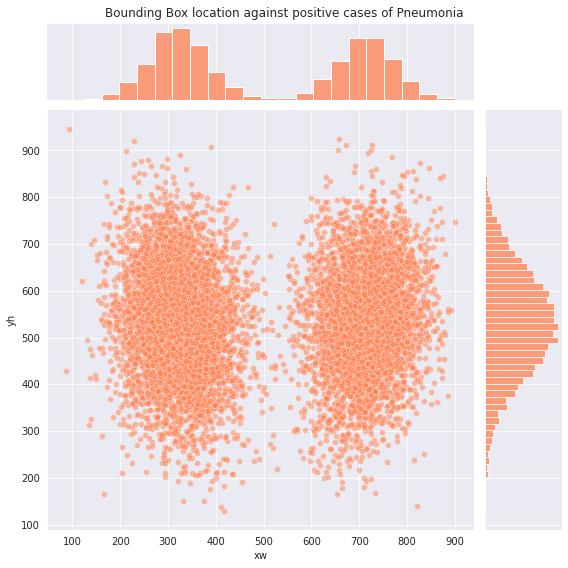

In [ ]:
print('Plot x and y centers of bounding box\n')
boundbox = tdpk1[tdpk1['Target'] == 1]
boundbox['xw'] = boundbox['x'] + boundbox['width']/2
boundbox['yh'] = boundbox['y'] + boundbox['height']/2

g = sns.jointplot(x = boundbox['xw'], y = boundbox['yh'], data = boundbox,
                  kind = 'scatter', alpha = 0.5, size = 8, color="coral")
plt.suptitle('Bounding Box location against positive cases of Pneumonia')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)

In [ ]:
# function to draw bounding box center points
def bboxscat(data, color_point, color_window, text):
    fig, ax = plt.subplots(1, 1, figsize = (7, 7))
    plt.title('Plotting points of lung opacity\n{}'.format(text))
    data.plot.scatter(x = 'xw', y = 'yh', xlim = (0, 1024), ylim = (0, 1024), ax = ax, alpha = 0.8, marker = ".", color = color_point)
    for i, crt_sample in data.iterrows():
               ax.add_patch(Rectangle(xy = (crt_sample['x'], crt_sample['y']), width = crt_sample['width'], height = crt_sample['height'], alpha = 3.5e-3, color = color_window))


In [ ]:
# function to plot graph

def plotgraph(data_file, columns, hue = False, width = 15, showdistribution = True):
    if (hue):
        print('Creating graph for : {} and {}\n'.format(columns, hue))
    else:
        print('Creating graph for : {}\n'.format(columns))
    length = len(columns) * 6
    total = float(len(data_file))

    fig, axes = plt.subplots(nrows = len(columns) if len(columns) > 1 else 1, ncols = 1, figsize = (width, length))
    for index, content in enumerate(columns):
        plt.title(content)

    caxes = 0
    if (len(columns) > 1):
        caxes = axes[index]
    else:
        caxes = axes

    if (hue):
        sns.countplot(x = columns[index], data = data_file, ax = caxes, hue = hue)
    else:
        sns.countplot(x = columns[index], data = data_file, ax = caxes)

    if(showdistribution):
        for p in (caxes.patches):
            height = p.get_height()
            if (height > 0 and total > 0):
                caxes.text(p.get_x() + p.get_width()/2., height + 3, '{:1.2f}%'.format(100*height/total), ha = "center")

In [ ]:
plotscatter_PA = boundbox[boundbox['ViewPosition'] == 'PA'].sample(1000)
plotscatter_AP = boundbox[boundbox['ViewPosition'] == 'AP'].sample(1000)

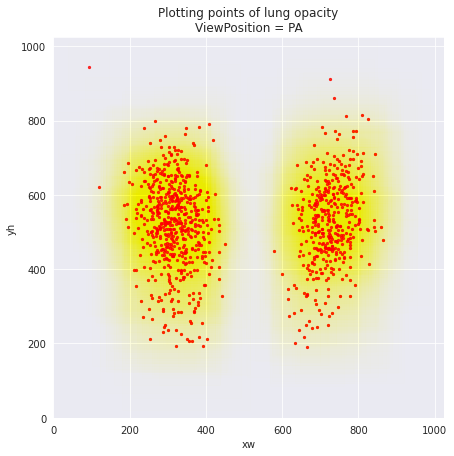

In [ ]:
bboxscat(plotscatter_PA, 'red', 'yellow', 'ViewPosition = PA')

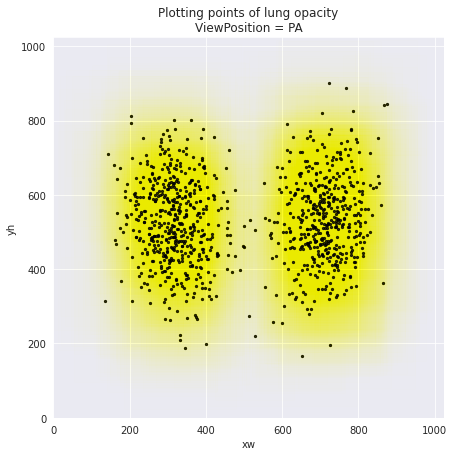

In [ ]:
bboxscat(plotscatter_AP, 'black', 'yellow', 'ViewPosition = PA')

In [ ]:
# Patient Sex
feature_dist(tdpk1, 'PatientSex')

Feature: PatientSex
M                             : 17216 which is 56.95% of the total data in the dataset
F                             : 13011 which is 43.04% of the total data in the dataset


Creating graph for : ['PatientSex']



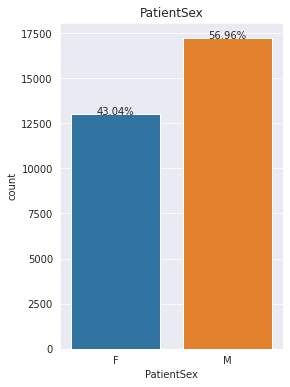

In [ ]:
plotgraph(data_file = tdpk1, columns = ['PatientSex'], hue = False, width = 4, showdistribution = True)


From above eda's it is shown that data split between male and female is divided as 57% abd 43% respectively

Creating graph for : ['PatientSex'] and class



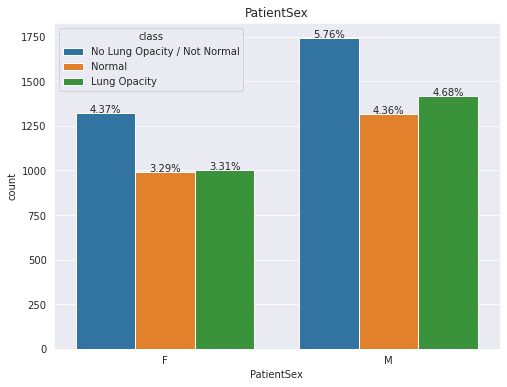

In [ ]:
plotgraph(data_file = training_data, columns = ['PatientSex'], hue = 'class', width = 8, showdistribution = True)


13.2% of the **FEMALE** population has been diagnosed with Pneumonia.
18.39% of total **MALE** population has been diagnosed with Opacity deducing Pneumonia.

In [ ]:
plotscatter_F = boundbox[boundbox['PatientSex'] == 'F'].sample(1000)
plotscatter_M = boundbox[boundbox['PatientSex'] == 'M'].sample(1000)

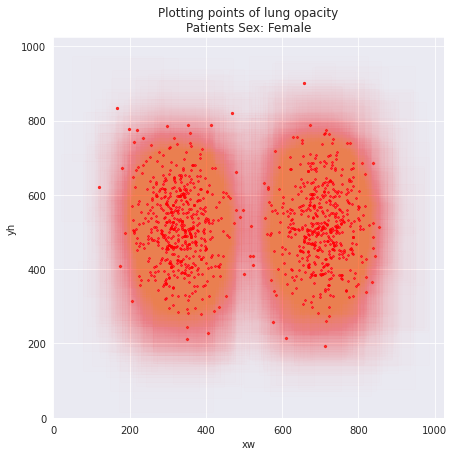

In [ ]:
bboxscat(plotscatter_F, 'red', 'coral', 'Patients Sex: Female')

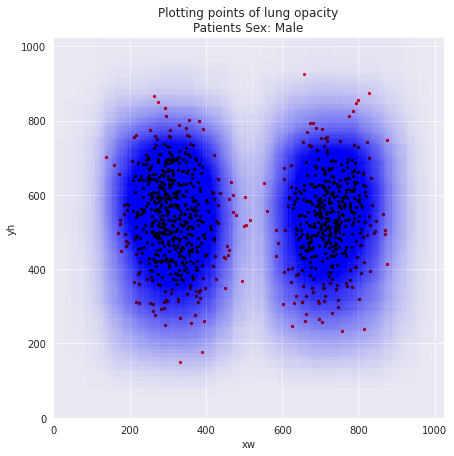

In [ ]:
bboxscat(plotscatter_M, 'red', 'blue', 'Patients Sex: Male')

We can see from above plots thatthat the center of bounbding boxes has been spread evenly with few outliers .

In [ ]:
# Patient Age
print('The minimum and maximum recorded age of the patients are {0} and {1} respectively.'.format(tdpk1['PatientAge'].min(), tdpk1['PatientAge'].max()))


The minimum and maximum recorded age of the patients are 1 and 155 respectively.


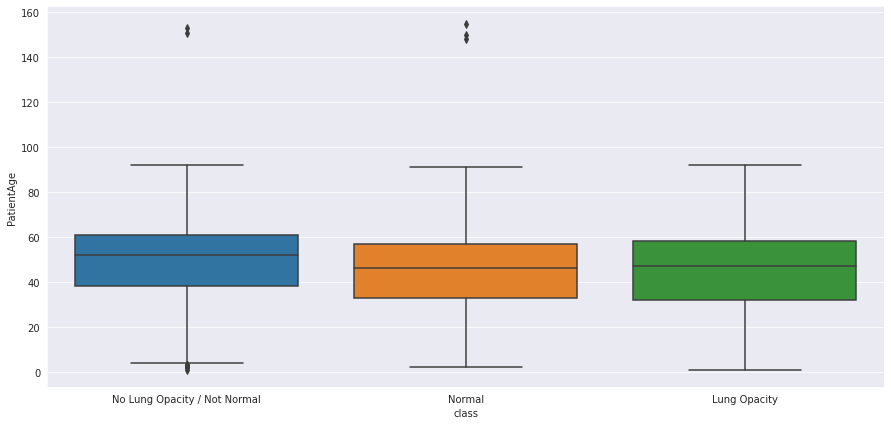

In [ ]:
plt.figure(figsize=(15,7))
sns.boxplot(x='class', y='PatientAge', data= tdpk1)
plt.show()

The  class which has no pneuomia has few outliers , their age is somewhere around 150 years, which are outliers.  
Overall Distrubution of Age looks normal with very little skew,  distubution of Patients age who have penuomonia are a left skewed

In [ ]:
# find outliers ages for removal

age25 = np.percentile(tdpk1['PatientAge'], 25)
age75 = np.percentile(tdpk1['PatientAge'], 75)
iqr_age = age75 - age25
cutoff_age = 1.5 * iqr_age

low_lim_age = age25 - cutoff_age
upp_lim_age = age75 + cutoff_age

outlier_age = [x for x in tdpk1['PatientAge'] if x < low_lim_age or x > upp_lim_age]

print('The number of outliers in `PatientAge` out of 30277 records are : {0}\n'.format(len(outlier_age)))
print('The ages which are in the outlier categories are : {0}\n'.format(outlier_age))

The number of outliers in `PatientAge` out of 30277 records are : 5

The ages which are in the outlier categories are : [148, 151, 153, 150, 155]



We observe 5 outlier ages in between 140 & 160 year. Also, from above boxplot, maximum numbers of patients recorded belong to 50-60 years of age.

In [ ]:
print('Removing the outliers from `PatientAge`')
# removing ages above 110 years for avoiding outliers
tdpk1['PatientAge'] = tdpk1['PatientAge'].clip(tdpk1['PatientAge'].min(), 110)
tdpk1['PatientAge'].describe().astype(int)

Removing the outliers from `PatientAge`


count     30227
unique       93
top          58
freq        955
Name: PatientAge, dtype: int64

Creating graph for : ['PatientAge']



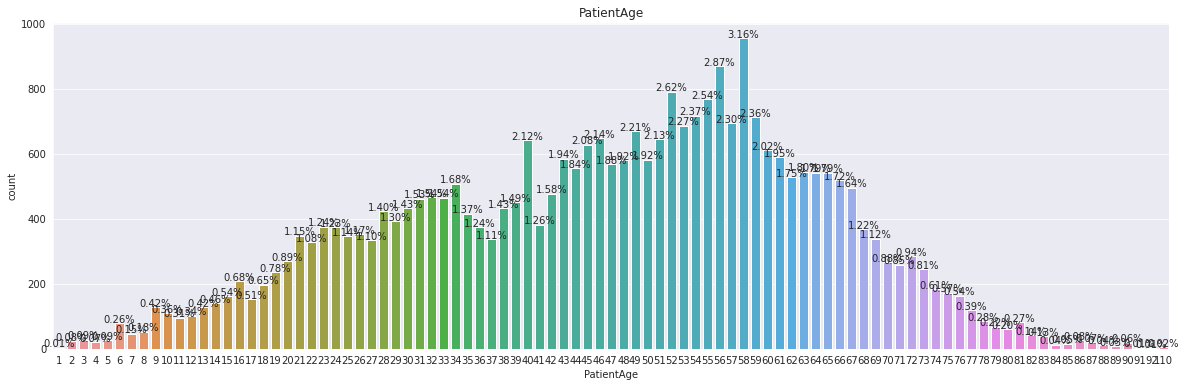

In [ ]:
plotgraph(data_file = tdpk1, columns = ['PatientAge'], width = 20, showdistribution = True)


Distribution of `Age`: Overall and Target = 1


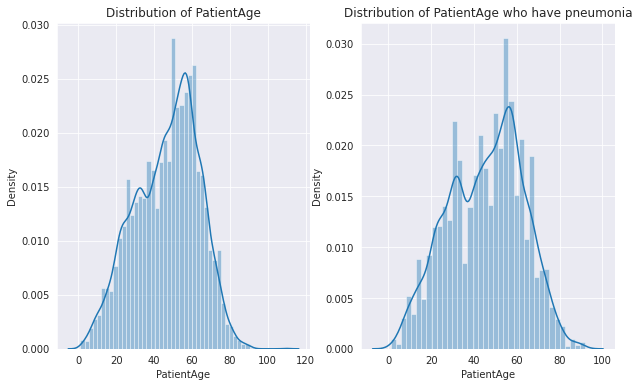

In [ ]:
print('Distribution of `Age`: Overall and Target = 1')
fig = plt.figure(figsize = (10, 6))

ax = fig.add_subplot(121)
g = (sns.distplot(tdpk1['PatientAge']).set_title('Distribution of PatientAge'))

ax = fig.add_subplot(122)
g = (sns.distplot(tdpk1.loc[tdpk1['Target'] == 1, 'PatientAge']).set_title('Distribution of PatientAge who have pneumonia'))


For us to have a more clear idea, we will introduce a new column Patient Age Range where the patients will be placed in an age group of 10's,i.e: 0-10, 10-20, 20-30 ...etc.

In [ ]:
custom_array = np.linspace(0, 110, 12)
tdpk1['PatientAgeRange'] = pd.cut(tdpk1['PatientAge'], custom_array)
tdpk1['PatientAgeRange'].value_counts()

(50.0, 60.0]      7446
(40.0, 50.0]      5671
(60.0, 70.0]      4730
(30.0, 40.0]      4551
(20.0, 30.0]      3704
(10.0, 20.0]      1688
(70.0, 80.0]      1637
(0.0, 10.0]        515
(80.0, 90.0]       275
(90.0, 100.0]        5
(100.0, 110.0]       5
Name: PatientAgeRange, dtype: int64

In [ ]:
tdpk1

,patientId,x,y,width,height,Target,class,path,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing,PatientAgeRange
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/stage_2_train_images/0004cfab-14fd-4e...,CR,51,F,CHEST,PA,WSD,1024,1024,0.143,"(50.0, 60.0]"
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/stage_2_train_images/00313ee0-9eaa-42...,CR,48,F,CHEST,PA,WSD,1024,1024,0.194,"(40.0, 50.0]"
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/stage_2_train_images/00322d4d-1c29-49...,CR,19,M,CHEST,AP,WSD,1024,1024,0.168,"(10.0, 20.0]"
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,/content/stage_2_train_images/003d8fa0-6bf1-40...,CR,28,M,CHEST,PA,WSD,1024,1024,0.143,"(20.0, 30.0]"
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,/content/stage_2_train_images/00436515-870c-4b...,CR,32,F,CHEST,AP,WSD,1024,1024,0.139,"(30.0, 40.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity,/content/stage_2_train_images/c1ec14ff-f6d7-4b...,CR,54,M,CHEST,AP,WSD,1024,1024,0.139,"(50.0, 60.0]"
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,Normal,/content/stage_2_train_images/c1edf42b-5958-47...,CR,46,F,CHEST,PA,WSD,1024,1024,0.143,"(40.0, 50.0]"
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal,/content/stage_2_train_images/c1f6b555-2eb1-42...,CR,45,M,CHEST,PA,WSD,1024,1024,0.168,"(40.0, 50.0]"
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity,/content/stage_2_train_images/c1f7889a-9ea9-4a...,CR,72,F,CHEST,AP,WSD,1024,1024,0.139,"(70.0, 80.0]"


Creating graph for : ['PatientAgeRange']



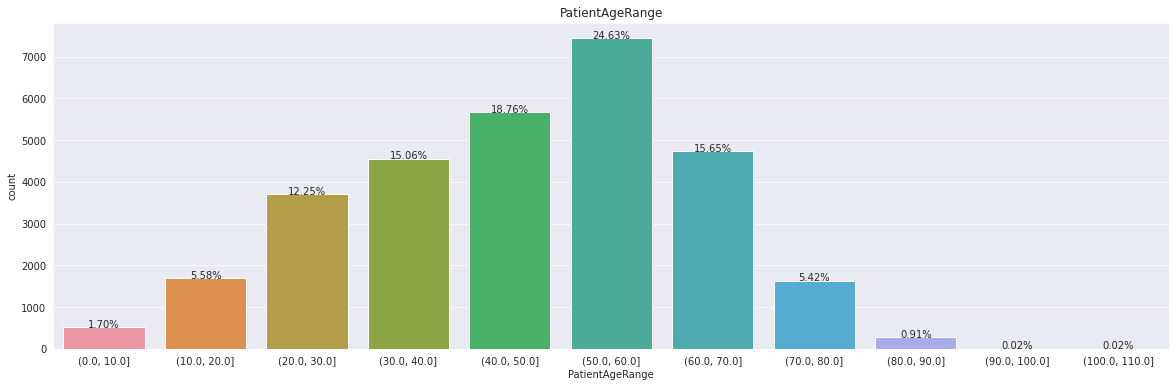

In [ ]:
 plotgraph(data_file = tdpk1, columns = ['PatientAgeRange'], width = 20, showdistribution = True)


Creating graph for : ['PatientAgeRange'] and PatientSex



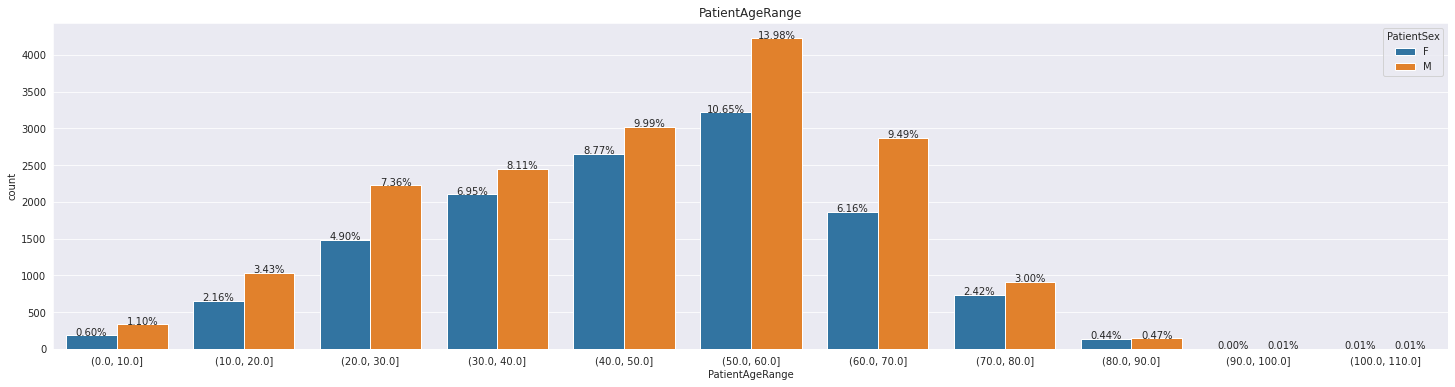

In [ ]:
plotgraph(data_file = tdpk1, columns = ['PatientAgeRange'], hue = 'PatientSex', width = 25, showdistribution = True)


Creating graph for : ['PatientAgeRange'] and class



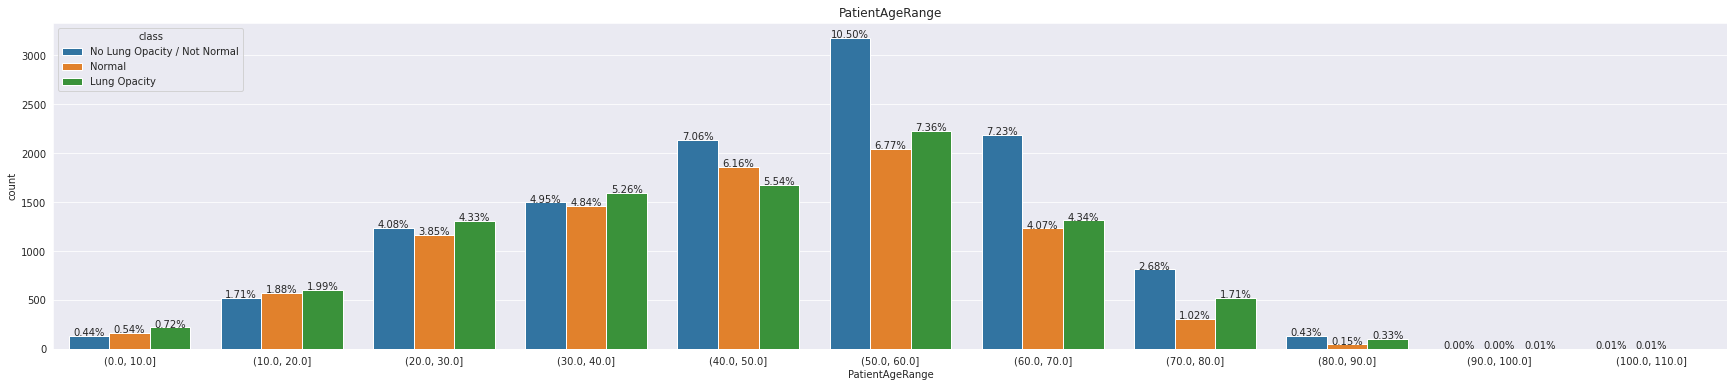

In [ ]:
plotgraph(data_file = tdpk1, columns = ['PatientAgeRange'], hue = 'class', width = 30, showdistribution = True)


The maximum number of patients in our dataset are between **50-60 years** of age contributing **24.63%** of total population.
Of this group, the females cover **10.65%** and males are **13.98%**
The same age group also contains the highest number of patients with diagnosed Pneuonia contributing **17.27%.**

In [ ]:
# Scatter charts below describes the distribution of Bounding boxes and pneumonia detected regions based on the age-group

data_age_19 = boundbox[boundbox['PatientAge'] < 20]
data_age_20_34 = boundbox[(boundbox['PatientAge'] >= 20) & (boundbox['PatientAge'] < 35)]
data_age_35_49 = boundbox[(boundbox['PatientAge'] >= 35) & (boundbox['PatientAge'] < 50)]
data_age_50_64 = boundbox[(boundbox['PatientAge'] >= 50) & (boundbox['PatientAge'] < 65)]
data_age_65 = boundbox[boundbox['PatientAge'] >= 65]

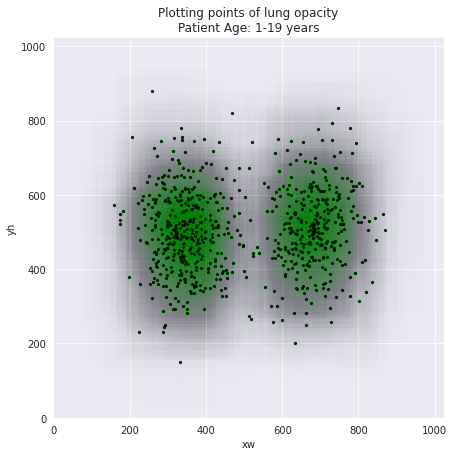

In [ ]:
bboxscat(data_age_19,'black', 'green', 'Patient Age: 1-19 years')


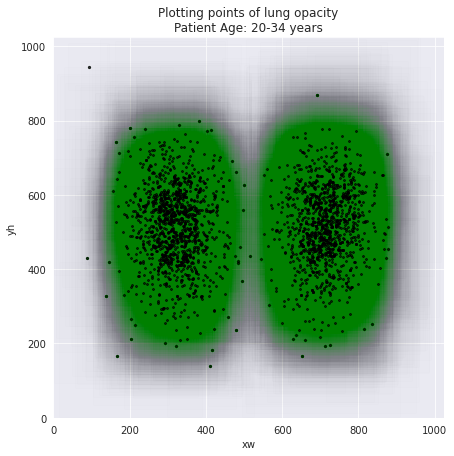

In [ ]:
bboxscat(data_age_20_34,'black', 'green', 'Patient Age: 20-34 years')


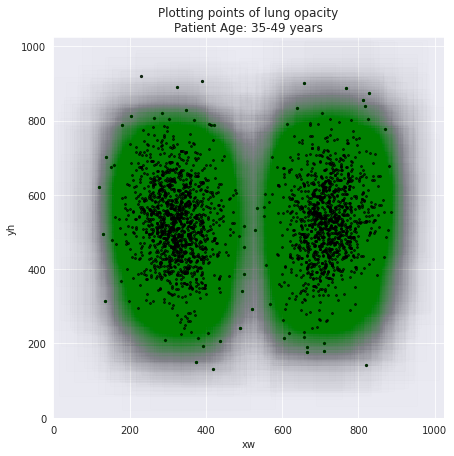

In [ ]:
bboxscat(data_age_35_49,'black', 'green', 'Patient Age: 35-49 years')

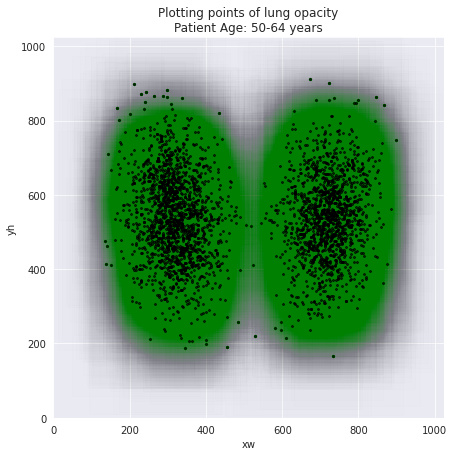

In [ ]:
bboxscat(data_age_50_64,'black', 'green', 'Patient Age: 50-64 years')

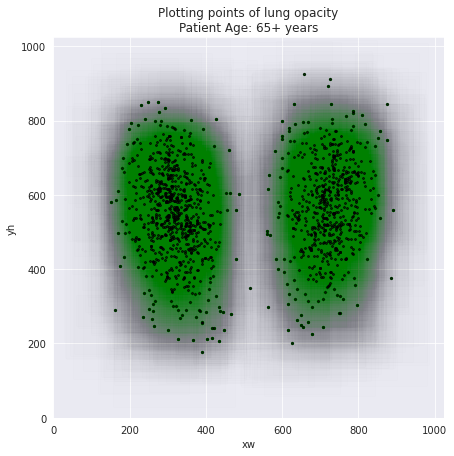

In [ ]:
bboxscat(data_age_65,'black', 'green', 'Patient Age: 65+ years')

####**Plotting DICOM Images without and with bounding box**####

In [ ]:
# to access and view training dicom image files

train_images_dir = 'stage_2_train_images'
train_images = [f for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))]
test_images_dir ='stage_2_test_images'
test_images = [f for f in os.listdir(test_images_dir) if os.path.isfile(os.path.join(test_images_dir, f))]
print('5 Training images', train_images[:5]) # Print the first 5 Training images
print ('5 Test images', test_images[:5]) # Print the first 5 Test images

5 Training images ['7358decc-5bb3-4fad-8eab-c3c6459d2c11.dcm', 'b29e295b-367c-4787-90da-e9d506bdce45.dcm', 'f373e392-055d-4a9b-8d74-489df686d28d.dcm', '92d8d10a-d3b3-41a3-be93-ad21dea0d5bf.dcm', 'cfc6d411-d8cc-407d-9dd7-dfc5a0cc25b7.dcm']
5 Test images ['13659019-299a-47bc-ac85-25500b625fde.dcm', '1eeecd10-16a2-476f-8d81-867d5480bf01.dcm', '02b7bd21-0ca3-48b0-b98c-dd85a7ad1c0f.dcm', '298e22d6-f3e7-4f3d-8196-d95f7c3f992b.dcm', '121df7c8-b968-4a56-847f-063915515223.dcm']


In [ ]:
tdpk1

,patientId,x,y,width,height,Target,class,path,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing,PatientAgeRange
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/stage_2_train_images/0004cfab-14fd-4e...,CR,51,F,CHEST,PA,WSD,1024,1024,0.143,"(50.0, 60.0]"
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/stage_2_train_images/00313ee0-9eaa-42...,CR,48,F,CHEST,PA,WSD,1024,1024,0.194,"(40.0, 50.0]"
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/stage_2_train_images/00322d4d-1c29-49...,CR,19,M,CHEST,AP,WSD,1024,1024,0.168,"(10.0, 20.0]"
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,/content/stage_2_train_images/003d8fa0-6bf1-40...,CR,28,M,CHEST,PA,WSD,1024,1024,0.143,"(20.0, 30.0]"
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,/content/stage_2_train_images/00436515-870c-4b...,CR,32,F,CHEST,AP,WSD,1024,1024,0.139,"(30.0, 40.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity,/content/stage_2_train_images/c1ec14ff-f6d7-4b...,CR,54,M,CHEST,AP,WSD,1024,1024,0.139,"(50.0, 60.0]"
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,Normal,/content/stage_2_train_images/c1edf42b-5958-47...,CR,46,F,CHEST,PA,WSD,1024,1024,0.143,"(40.0, 50.0]"
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal,/content/stage_2_train_images/c1f6b555-2eb1-42...,CR,45,M,CHEST,PA,WSD,1024,1024,0.168,"(40.0, 50.0]"
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity,/content/stage_2_train_images/c1f7889a-9ea9-4a...,CR,72,F,CHEST,AP,WSD,1024,1024,0.139,"(70.0, 80.0]"


In [ ]:
import matplotlib.patches as patches

# function for dicom files to be accessed and plotted
def inspectImages(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']
        dcm_file = '/content/stage_2_train_images/' +'{}.dcm'.format(patientImage)
        data_row_img_data = dcm.read_file(dcm_file)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(dcm_file)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\Bounds: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'],
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        label = data_row["class"]
        if not math.isnan(data_row['x']):
            x, y, width, height  =  data_row['x'],data_row['y'],data_row['width'],data_row['height']
            rect = patches.Rectangle((x, y),width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
            ax[i//3, i%3].add_patch(rect)

    plt.show()

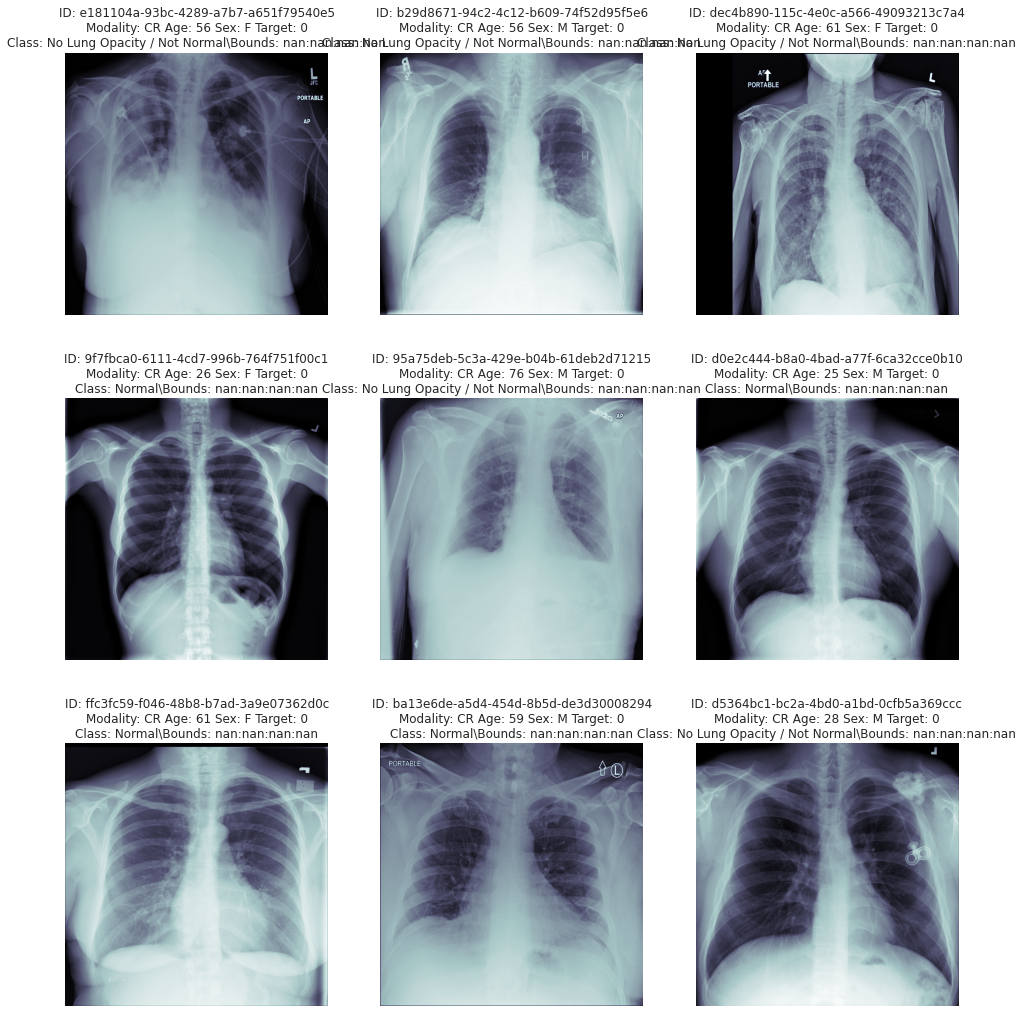

In [ ]:
inspectImages(tdpk1[tdpk1['Target']==0].sample(9))

All above subplots are of the images which belong to either "Normal" or "No Lung Opacity / Not Normal", hence no bounding box is observed.



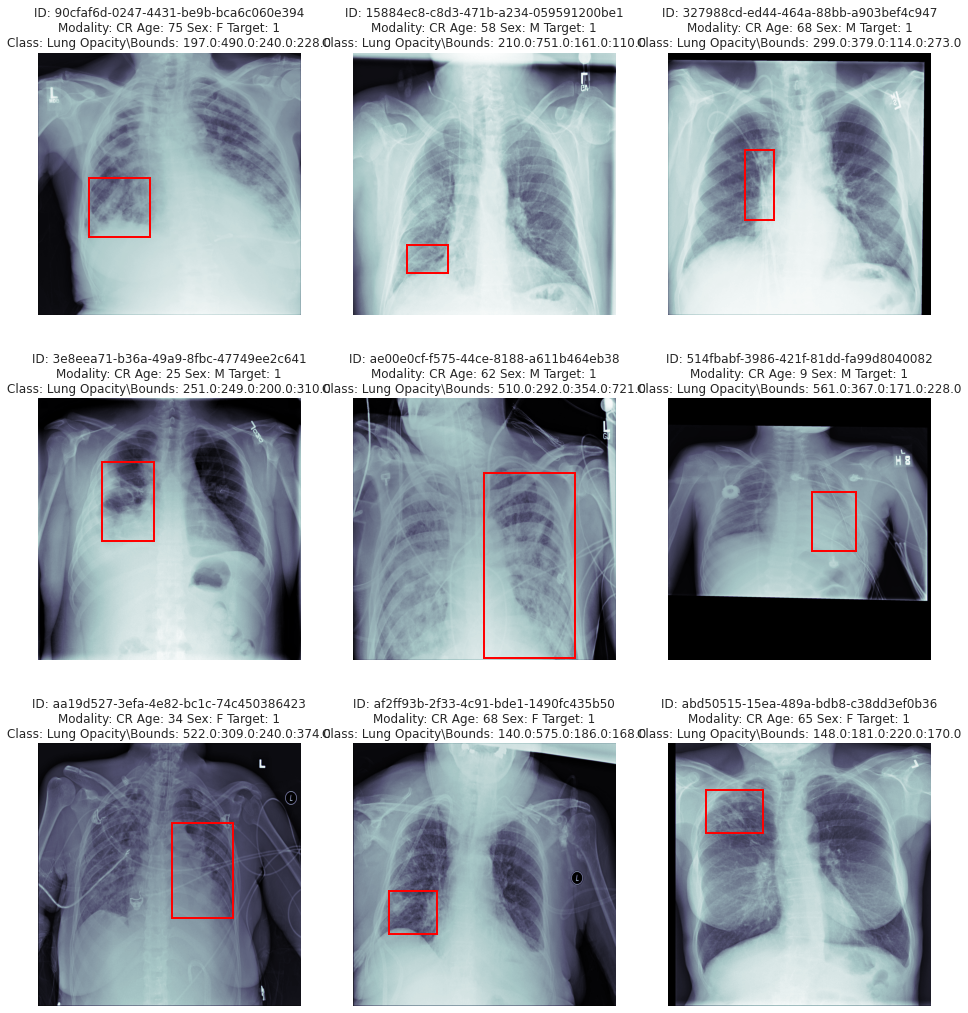

In [ ]:
inspectImages(tdpk1[tdpk1['Target']==1].sample(9))

All above subplots, we can see that the area covered by the red box depicts the area of interest, i.e. the area in which the opacity is observed in the Lungs.

### **EDA OVERVIEW** ###

* The training dataset ( csv files and the training images) contains information of 26684 unique patients. Out of these 26684 unique patients some of these have multiple entries in the both of the csv files.

* Most of the recorded patient belong to Target = 0, having no Pneumonia.
* Some of the patients have more than one bounding box.
* The classes "No Lung Opacity / Not Normal" and "Normal" is associated with Target = 0 whereas "Lung Opacity" belong to Target = 1
* The images are present in dicom format, from which information like PatientAge, PatientSex, ViewPosition etc are obtained There are two ways from which images were obtained: AP and PA. The age ranges from 1-155 (which were further clipped to 110).
* The centers of the bounding box are spread out over the entire region of the lungs. But there are some centers which are outliers.
* Dicom Images without and with bounding boxes shown.

### **Model Building** ###

In [ ]:
folders = ['stage_2_train_images', 'stage_2_test_images']
path = '/content'

# Checking the number of files in folders
for f in folders:
    print('No. of files in {0} : {1}'.format(f,len(os.listdir(os.path.join(path,f)))))

No. of files in stage_2_train_images : 26685
No. of files in stage_2_test_images : 3001


In [ ]:
# Creating new column names and mapping from the original Dataframe
ColName = ['patientid','x1','y1','w1','h1','x2','y2','w2','h2','Target','Class','Gender']

# Iterating over patientId to get unique record
final_list=[]
for ids in np.unique(labels['patientId']):
    meta_info = dcm.read_file('/content/stage_2_train_images/'+ids+'.dcm')
    if len(list(labels['x'][labels['patientId']==ids]))>1:  # We are considering only patientId with 2 bounding boxes
        ls=[]
        ls.append(ids)
        ls.append(list(labels[labels['patientId']==ids]['x'])[0])
        ls.append(list(labels[labels['patientId']==ids]['y'])[0])
        ls.append(list(labels[labels['patientId']==ids]['width'])[0])
        ls.append(list(labels[labels['patientId']==ids]['height'])[0])
        ls.append(list(labels[labels['patientId']==ids]['x'])[1])
        ls.append(list(labels[labels['patientId']==ids]['y'])[1])
        ls.append(list(labels[labels['patientId']==ids]['width'])[1])
        ls.append(list(labels[labels['patientId']==ids]['height'])[1])
        ls.append(list(labels[labels['patientId']==ids]['Target'])[1])
        ls.append(list(class_info[class_info['patientId']==ids]['class'])[0])
        ls.append(meta_info.PatientSex)
        final_list.append(ls)
    else:
        ls=[ids,0,0,0,0,0,0,0,0,0]
        ls.append(list(class_info[class_info['patientId']==ids]['class'])[0])
        ls.append(meta_info.PatientSex)
        final_list.append(ls)

# Saving the dataframe
final_df = pd.DataFrame(final_list, columns=ColName)

In [ ]:
# Removing the 3rd class (No Lung Opacity / Not Normal) from dataframe
final_df = final_df[final_df['Class'] != 'No Lung Opacity / Not Normal']

print('The final_df has {0} rows and {1} columns.\n'.format(final_df.shape[0],final_df.shape[1]))
# First 5 rows of dataframe
final_df.head(5)

The final_df has 14863 rows and 12 columns.



,patientid,x1,y1,w1,h1,x2,y2,w2,h2,Target,Class,Gender
1,000924cf-0f8d-42bd-9158-1af53881a557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Normal,F
2,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,660.0,375.0,146.0,402.0,1,Lung Opacity,F
3,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,83.0,227.0,296.0,438.0,1,Lung Opacity,M
4,001031d9-f904-4a23-b3e5-2c088acd19c6,66.0,160.0,373.0,608.0,552.0,164.0,376.0,676.0,1,Lung Opacity,M
5,0010f549-b242-4e94-87a8-57d79de215fc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Normal,M


In [ ]:
final_df.groupby('Target').count()['Class']

Target
0    11465
1     3398
Name: Class, dtype: int64

We start with data pre-processing .Here we have images in dicom format so first we need to save them in an array so that we could train model with that and secondly we got images in high resolution of  1024x1024 so we need to downsize to 128x128,reason for using 128 size images is that we will be using Transfer Learning model called MobileNet pretrained on ImageNet Dataset.for prediction of classes &also we need to predict coordinates of bounding boxes. So, we will be using UNET architecture for the problem solution. For this we created a user defined function and that function will return training images array(X_train) with corresponding mask and target variable.

In [ ]:
# Fuction which will return X_train, Mask and Target

def image_resizer_mask_generator(path, new_im_w, new_im_h):
    listing=[x+'.dcm' for x in final_df['patientid'].unique()]

    # Initialize X_train
    X_train = np.zeros((len(listing), new_im_w, new_im_h, 3))
    # Initialize Mask
    mask = np.zeros((len(listing), new_im_w, new_im_h))
    # Initialize Target
    target = np.zeros(len(listing))
    i=1
    for index in range(len(listing)):
        os.chdir(os.path.join(path,'stage_2_train_images'))
        img = dcm.dcmread(listing[index])  # Read Dicom image
        img_arr = img.pixel_array
        img_arr = np.stack([img_arr]*3, axis=2) # Convert to 3 channels
        orig_im_h, orig_im_w, channels = img_arr.shape
        img_arr_resize = cv2.resize(img_arr, (new_im_w, new_im_h))
        # Feed to X_train
        X_train[index] = np.array(img_arr_resize, dtype=np.float32)
        ids=listing[index].replace('.dcm','')
        ids,x1,y1,w1,h1,x2,y2,w2,h2,tgt,label = [np.array(final_df[final_df['patientid']==ids])[0][i] for i in range(11)]
        target[index] = tgt
        if x1>0:
            ratio_w=new_im_w/orig_im_w
            ratio_h=new_im_h/orig_im_h
            new_x1=int(x1*ratio_w)
            new_y1=int(y1*ratio_h)
            new_x2=int(x2*ratio_w)
            new_y2=int(y2*ratio_h)
            new_w1=int(w1*ratio_w)
            new_h1=int(h1*ratio_h)
            new_w2=int(w2*ratio_w)
            new_h2=int(h2*ratio_h)
            mask[index][new_y1:new_y1+new_h1, new_x1:new_x1+new_w1] = 1
            mask[index][new_y2:new_y2+new_h2, new_x2:new_x2+new_w2] = 1
        i+=1

    return X_train, mask, target

In [ ]:
(X_train, mask, target) = image_resizer_mask_generator('/content', 128, 128)  # Resizing images to 128 x 128


In [ ]:
# Split target = 0
X_train_0 = X_train[target==0]
mask_0 = mask[target==0]
target_0 = target[target==0]
print('Length for Target=0 : {0}'.format(len(target_0)))

# Split target = 1
X_train_1 = X_train[target==1]
mask_1 = mask[target==1]
target_1 = target[target==1]
print('Length for Target=1 : {0}'.format(len(target_1)))

# Balance the Class using random function
X_train_balanced = np.zeros((2*len(target_1), X_train_1.shape[1], X_train_1.shape[2], X_train_1.shape[3]))
mask_balanced = np.zeros((2*len(target_1), mask_1.shape[1], mask_1.shape[2]))
target_balanced = np.zeros((2*len(target_1)))

index=0
for i in (np.random.choice(len(target_0), len(target_1), replace=False)):
    X_train_balanced[index] = X_train_0[i]
    mask_balanced[index] = mask_0[i]
    target_balanced[index] = target_0[i]
    index+=1

j=0
for idx in np.arange(len(target_1), X_train_balanced.shape[0], 1):
    X_train_balanced[idx] = X_train_1[j]
    mask_balanced[idx] = mask_1[j]
    target_balanced[idx] = target_1[j]
    j+=1

Length for Target=0 : 11465
Length for Target=1 : 3398


In [ ]:
len(X_train_balanced), len(mask_balanced), len(target_balanced)

(6796, 6796, 6796)

In [ ]:
# One hot encoding target variable
target_encoded = tf.keras.utils.to_categorical(target_balanced, num_classes=2)

# Shuffling the whole data
from sklearn.utils import shuffle
X_train_balanced, mask_balanced, target_encoded = shuffle(X_train_balanced, mask_balanced, target_encoded)


In [ ]:
# Deleted variables to save memory
del X_train
del mask
del target

Before going for training , we need to divide whole set into training and evaluation set and here for Classification model we took first 5000 images as training set and remaining images is for evaluation of the performance on unseen data. And for the prediction of bounding boxes using UNET architecture we are using different set for training and evaluation. As we thought that if the person is normal then we don’t need to do any prediction for those images. Hence, we are feeding only those images which has some abnormality present and for them we need to highlight those affected area via bounding boxes. For UNET we created different set containing only images with target as 1 (Lung Opacity) and tried to predict mask and bounding boxes thereafter. For Evaluation set we took first 10 images and remaining images for training the UNET model.



In [ ]:
# Taking first 5000 records for training and rest for evaluation
Train_X = X_train_balanced[0:5000,:,:,:]
Eval_X = X_train_balanced[5000:,:,:,:]

# Train_mask = mask_balanced[0:5000,:,:]
# Eval_mask = mask_balanced[5000:,:,:]

Train_y = target_encoded[0:5000]
Eval_y = target_encoded[5000:]

# For computation restrictions, we are training UNET only on images which has targer as 1 (Lung Opacity).
# Taking first 10 records for evaluation and rest for training
Train_X_unet = X_train_1[10:]
Eval_X_unet = X_train_1[0:10]

Train_mask_unet = mask_1[10:]
Eval_mask_unet = mask_1[0:10]

**Base Classifier Model**
* Used TensorFlow 2.0 and Keras wrapper for building classification model.
* Used Conv layers of 64 and 128 features with same padding.
* Applied 2x2 kernel Maxpooling2D layers to make the model lighter
* Relu is used as activation function.
*After flattening of feature vector, we applied 2 dense layers and last layer with SoftMax activation.

In [ ]:
# Function to plot accuracy and loss
def plot_accuracy_loss(history, model_type='UNET'):
    plt.figure(figsize=(20,6))

    # Plotting the Train accuracy, Validation accuracy vs number of Epochs
    plt.subplot(1, 2, 1)
    if(model_type=='CLF'):
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.ylabel('Accuracy')
    else:
        plt.plot(history.history['dice_coefficient'])
        plt.plot(history.history['val_dice_coefficient'])
        plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.title('Model Accuracy')
    plt.legend(['Train Accuracy', 'Val Accuracy'], loc='lower right')

    # Plotting the Train loss, Validation loss vs number of Epochs
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train Loss', 'Val Loss'], loc='upper right')

    plt.show()

In [ ]:
# Model Evaluation
def evaluate_model(model, Eval_X, Eval_y, Train_X, Train_y, model_type='UNET'):
    eval_results = model.evaluate(Eval_X, Eval_y)
    train_results = model.evaluate(Train_X, Train_y)
    if(model_type=='CLF'):
        print('Accuracy on Evaluation set = {0:.2f}% & Loss on Eval set = {1:.4f}'.format(eval_results[1]*100, eval_results[0]))
        train_acc = round(train_results[1]*100, 2)
        eval_acc = round(eval_results[1]*100, 2)
    else:
        print('Dice Coefficient on Eval set = {0:.4f} & Loss on Eval set = {1:.4f}'.format(eval_results[1], eval_results[0]))
        train_acc = round(train_results[1], 4)
        eval_acc = round(eval_results[1], 4)

    train_loss = round(train_results[0], 4)
    eval_loss = round(eval_results[0], 4)

    return eval_acc, eval_loss, train_acc, train_loss

In [ ]:
# Dictionary to store the models, scores & loss
clf_model_scores = {'Model':[], 'Train Score':[], 'Eval Score':[], 'Train Loss':[], 'Eval Loss':[]}
unet_model_scores = {'Model':[], 'Train Score':[], 'Eval Score':[], 'Train Loss':[], 'Eval Loss':[]}

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def clf_report_and_conf_matrix(model, Eval_X, Eval_y):
    prediction = model.predict(Eval_X)  # Predict using the model
    y_pred = np.argmax(prediction, axis=1)
    y_actual = np.argmax(Eval_y, axis=1)
    print('Classification Report:\n')
    print(classification_report(y_actual, y_pred))  # Print Classification report
    print('\n')

    # Confusion matrix to evaluate the accuracy of a classification
    cm = confusion_matrix(y_actual, y_pred)
    df_cm = pd.DataFrame(cm,
                        index = [i for i in ['Non-Pneumonia','Pneumonia']],
                        columns = [i for i in ['Non-Pneumonia','Pneumonia']])
    plt.figure(figsize = (7,5))
    sns.heatmap(df_cm, annot=True ,fmt='g', cmap='coolwarm', linewidths=1)  # Display confusion matrix
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# Applying callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-6, mode='min')
# checkpoint = tf.keras.callbacks.ModelCheckpoint('model-{loss:.2f}.h5', monitor='loss', save_best_only=True, save_weights_only=True, mode='min', save_freq=1)


In [ ]:
# Define Dice Coefficient
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

In [ ]:
# Define Loss function
def loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())


**Sequential CNN Model**

In [ ]:
# Apply Pre-processing
Train_X_clf_1 = tf.keras.applications.mobilenet.preprocess_input(np.copy(Train_X))
Eval_X_clf_1 = tf.keras.applications.mobilenet.preprocess_input(np.copy(Eval_X))

# Basic CNN Model Architecture
# Sequential model
model_clf_1 = tf.keras.models.Sequential()

# Add the first convolution layer
model_clf_1.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(128, 128, 3)))
# Add the first pooling layer
model_clf_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Add the second convolution layer
model_clf_1.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
# Add the second pooling layer
model_clf_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer
model_clf_1.add(tf.keras.layers.Dropout(0.2))

# Add the third convolution layer
model_clf_1.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
# Add the third pooling layer
model_clf_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer
model_clf_1.add(tf.keras.layers.Dropout(0.2))

# Flatten the matrix into vector
model_clf_1.add(tf.keras.layers.Flatten())
model_clf_1.add(tf.keras.layers.Dropout(0.2))

# Add a dense (or fully connected) layer
model_clf_1.add(tf.keras.layers.Dense(32, activation='relu'))
# Add output layer
model_clf_1.add(tf.keras.layers.Dense(2, activation='softmax'))

# Model summary
model_clf_1.summary()


# Define optimizer and compile the model
model_clf_1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 128)       0         
__________

TypeError: ignored

In [ ]:
# Fit the model
history_clf_1 = model_clf_1.fit(Train_X_clf_1, Train_y, epochs=40, batch_size=32, validation_split=0.2, callbacks=[early_stop, reduce_lr])

In [ ]:
# Plot accuracy and loss
plot_accuracy_loss(history=history_clf_1, model_type='CLF')

In [ ]:
# Model Evaluation
eval_acc_clf_1, eval_loss_clf_1, train_acc_clf_1, train_loss_clf_1 = evaluate_model(model_clf_1, Eval_X_clf_1, Eval_y, Train_X_clf_1, Train_y, 'CLF')


In [ ]:
#Classification report & Confusion matrix

clf_report_and_conf_matrix(model_clf_1, Eval_X_clf_1, Eval_y)

In [ ]:
# Append the scores & loss
clf_model_scores['Model'].append('Basic CNN')
clf_model_scores['Train Score'].append(train_acc_clf_1)
clf_model_scores['Eval Score'].append(eval_acc_clf_1)
clf_model_scores['Train Loss'].append(train_loss_clf_1)
clf_model_scores['Eval Loss'].append(eval_loss_clf_1)

In [ ]:
# Plot the model
tf.keras.utils.plot_model(model_clf_1, show_shapes=True)

In [ ]:
del Train_X_clf_1
del Eval_X_clf_1

**MobileNet Classifier Model**

In [ ]:
# Apply Pre-processing
Train_X_clf_2 = tf.keras.applications.mobilenet.preprocess_input(np.copy(Train_X))
Eval_X_clf_2 = tf.keras.applications.mobilenet.preprocess_input(np.copy(Eval_X))

# Instantiates the MobileNet architecture
model_clf_2_temp = tf.keras.applications.mobilenet.MobileNet(input_shape=(128, 128, 3), alpha=1.0, include_top=False, weights='imagenet')

# Previous layers are non trainable
for layer in model_clf_2_temp.layers:
    layer.trainable=False

# Classification layers
y = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(model_clf_2_temp.get_layer('conv_pw_13_relu').output)
y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), activity_regularizer=tf.keras.regularizers.l1(0.01))(y)
y = tf.keras.layers.Dropout(0.5)(y)
y = tf.keras.layers.Dense(64, activation='relu')(y)
y = tf.keras.layers.Dropout(0.5)(y)
y = tf.keras.layers.Dense(2, activation='softmax')(y)

model_clf_2 = tf.keras.Model(inputs=model_clf_2_temp.input, outputs=y)

# Model summary
model_clf_2.summary()


# Define optimizer and compile the model
model_clf_2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [ ]:
# Fit the model
history_clf_2 = model_clf_2.fit(Train_X_clf_2, Train_y, epochs=40, batch_size=32, validation_split=0.2, callbacks=[early_stop, reduce_lr])

In [ ]:
# Plot accuracy and loss
plot_accuracy_loss(history=history_clf_2, model_type='CLF')

In [ ]:
# Model Evaluation
eval_acc_clf_2, eval_loss_clf_2, train_acc_clf_2, train_loss_clf_2 = evaluate_model(model_clf_2, Eval_X_clf_2, Eval_y, Train_X_clf_2, Train_y, 'CLF')


In [ ]:
# Classification report & Confusion matrix
clf_report_and_conf_matrix(model_clf_2, Eval_X_clf_2, Eval_y)

In [ ]:
# Append the scores & loss
clf_model_scores['Model'].append('MobileNet')
clf_model_scores['Train Score'].append(train_acc_clf_2)
clf_model_scores['Eval Score'].append(eval_acc_clf_2)
clf_model_scores['Train Loss'].append(train_loss_clf_2)
clf_model_scores['Eval Loss'].append(eval_loss_clf_2)

In [ ]:
# Plot the model
tf.keras.utils.plot_model(model_clf_2, show_shapes=True)

In [ ]:
del Train_X_clf_2
del Eval_X_clf_2

**InceptionV3 Classifier Model**

In [ ]:
# Apply Pre-processing
Train_X_clf_3 = tf.keras.applications.inception_v3.preprocess_input(np.copy(Train_X))
Eval_X_clf_3 = tf.keras.applications.inception_v3.preprocess_input(np.copy(Eval_X))

# Instantiates the InceptionV3 architecture
model_clf_3_temp = tf.keras.applications.inception_v3.InceptionV3(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Previous layers are non trainable
for layer in model_clf_3_temp.layers:
    layer.trainable=False

input = model_clf_3_temp.input

x = tf.keras.layers.Flatten()(model_clf_3_temp.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

model_clf_3 = tf.keras.Model(inputs=input, outputs=output)

# Model summary
model_clf_3.summary()


# Define optimizer and compile the model
model_clf_3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [ ]:
# Fit the model
history_clf_3 = model_clf_3.fit(Train_X_clf_3, Train_y, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stop, reduce_lr])

In [ ]:
# Plot accuracy and loss
plot_accuracy_loss(history=history_clf_3, model_type='CLF')

In [ ]:
# Model Evaluation
eval_acc_clf_3, eval_loss_clf_3, train_acc_clf_3, train_loss_clf_3 = evaluate_model(model_clf_3, Eval_X_clf_3, Eval_y, Train_X_clf_3, Train_y, 'CLF')


In [ ]:
# Classification report & Confusion matrix
clf_report_and_conf_matrix(model_clf_3, Eval_X_clf_3, Eval_y)


In [ ]:
# Append the scores & loss
clf_model_scores['Model'].append('InceptionV3')
clf_model_scores['Train Score'].append(train_acc_clf_3)
clf_model_scores['Eval Score'].append(eval_acc_clf_3)
clf_model_scores['Train Loss'].append(train_loss_clf_3)
clf_model_scores['Eval Loss'].append(eval_loss_clf_3)

In [ ]:
# Plot the model
tf.keras.utils.plot_model(model_clf_3, show_shapes=True)

In [ ]:
del Train_X_clf_3
del Eval_X_clf_3

**Model evaluation**

In [ ]:
# Convert dictionary into DataFrame
clf_models_df = pd.DataFrame(clf_model_scores)
clf_models_df

* MobileNet model has achieved good Train accuracy of 94% and Evaluation accuracy of 85%
* MobileNets are small, low-latency, low-power models parameterized to meet the resource constraints of a variety of use cases.
* Added Regularizers in the MobileNet model for better classification.

* MobileNets trade off between latency, size and accuracy while comparing favorably with popular models.

The other models were not good in-terms of predicting Pneumonia as precision and recall scores are poor.
Based on the accuracy, we've considered MobileNet as the best model for classification

In [ ]:
# Plotting the accuracy and loss for all classifier models
plt.figure(figsize=(20,6))

plt.subplot(1, 2, 1)
sns.lineplot(x=clf_models_df.Model, y=clf_models_df['Train Score'], marker='o', label='Train Score')
sns.lineplot(x=clf_models_df.Model, y=clf_models_df['Eval Score'], marker='o', label='Eval Score', linestyle='--')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(x=clf_models_df.Model, y=clf_models_df['Train Loss'], marker='s', label='Train Loss')
sns.lineplot(x=clf_models_df.Model, y=clf_models_df['Eval Loss'], marker='s', label='Eval Loss', linestyle='--')
plt.xlabel('Models')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.show()

**Observations**
* MobileNet model has achieved Train accuracy of 92% and Evaluation accuracy of 86%.
* Regularizers in the MobileNet model for better classification.
* MobileNets are small with low-latency, low-power models parameterized to meet the resource constraints of a variety of use cases.
* MobileNets trade off between latency, size and accuracy while comparing favorably with popular models.
* The other models were not good in-terms of predicting Pneumonia as precision and recall scores are poor.

**Based on the accuracy, we've considered MobileNet as the best model for classification.**

**MobileNet Unet Model**

In [ ]:
# Applying pre-processing

Train_X_unet1 = tf.keras.applications.mobilenet.preprocess_input(np.copy(Train_X_unet))
Eval_X_unet1 = tf.keras.applications.mobilenet.preprocess_input(np.copy(Eval_X_unet))

In [ ]:
# Instantiates the MobileNet architecture
model_unet1_temp = tf.keras.applications.mobilenet.MobileNet(input_shape=(128, 128, 3), alpha=1.0, include_top=False, weights='imagenet')

# Previous layers are non trainable
for layer in model_unet1_temp.layers:
    layer.trainable=False

blk0 = model_unet1_temp.input
blk1 = model_unet1_temp.get_layer('conv_pw_1_relu').output
blk2 = model_unet1_temp.get_layer('conv_pw_3_relu').output
blk3 = model_unet1_temp.get_layer('conv_pw_5_relu').output
blk4 = model_unet1_temp.get_layer('conv_pw_11_relu').output
blk5 = model_unet1_temp.get_layer('conv_pw_13_relu').output


In [ ]:
# Decoder Blocks
x = tf.keras.layers.Concatenate()([tf.keras.layers.UpSampling2D()(blk5), blk4])
x = tf.keras.layers.Concatenate()([tf.keras.layers.UpSampling2D()(x), blk3])
x = tf.keras.layers.Concatenate()([tf.keras.layers.UpSampling2D()(x), blk2])
x = tf.keras.layers.Concatenate()([tf.keras.layers.UpSampling2D()(x), blk1])
x = tf.keras.layers.Concatenate()([tf.keras.layers.UpSampling2D()(x), blk0])

x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', padding='same')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Conv2D(1, kernel_size=1, activation='sigmoid')(x)
x = tf.keras.layers.Reshape(target_shape=(128,128))(x)

In [ ]:
model_unet_mbu = tf.keras.Model(inputs=model_unet1_temp.input, outputs=x)
# Model summary
model_unet_mbu.summary()


# Define optimizer and compile the model
model_unet_mbu.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = loss,
    metrics = [dice_coefficient])

In [ ]:
# Fit the model
history_unet_mbu = model_unet_mbu.fit(Train_X_unet1, Train_mask_unet, epochs=20, batch_size=32, validation_split=0.35, callbacks=[early_stop, reduce_lr])


In [ ]:
# Plot accuracy and loss
plot_accuracy_loss(history=history_unet_mbu, model_type='UNET')

In [ ]:
# Model Evaluation
eval_acc_unet_1, eval_loss_unet_1, train_acc_unet_1, train_loss_unet_1 = evaluate_model(model_unet_mbu, Eval_X_unet1, Eval_mask_unet, Train_X_unet1, Train_mask_unet, 'UNET')


In [ ]:
# Append the scores & loss
unet_model_scores['Model'].append('MobileNet')
unet_model_scores['Train Score'].append(train_acc_unet_1)
unet_model_scores['Eval Score'].append(eval_acc_unet_1)
unet_model_scores['Train Loss'].append(train_loss_unet_1)
unet_model_scores['Eval Loss'].append(eval_loss_unet_1)

In [ ]:
# Plot the model
tf.keras.utils.plot_model(model_unet_mbu, show_shapes=True)

In [ ]:
del Train_X_unet1
del Eval_X_unet1

**Resnet34 Unet Model**

In [ ]:
!pip install segmentation_models

import segmentation_models
segmentation_models.set_framework('tf.keras')
from segmentation_models import Unet
from segmentation_models import get_preprocessing

In [ ]:
BACKBONE = 'resnet34'
preprocess_input_resnet = get_preprocessing(BACKBONE)

# Apply Pre-processing
Train_X_unet2 = preprocess_input_resnet(np.copy(Train_X_unet))
Eval_X_unet2 = preprocess_input_resnet(np.copy(Eval_X_unet))

In [ ]:
# Instantiates the Unet architecture with resnet34 as backbone
model_unet2 = Unet(BACKBONE, input_shape=(128, 128, 3), encoder_weights='imagenet')

# Model summary
model_unet2.summary()


# Define optimizer and compile the model
model_unet2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = loss,
    metrics = [dice_coefficient])

In [ ]:
# Fit the model

history_unet_2 = model_unet2.fit(Train_X_unet2, Train_mask_unet, epochs=20, batch_size=32, validation_split=0.35, callbacks=[early_stop, reduce_lr])


In [ ]:
# Plot accuracy and loss
plot_accuracy_loss(history=history_unet_2, model_type='UNET')

In [ ]:
# Model Evaluation
eval_acc_unet_2, eval_loss_unet_2, train_acc_unet_2, train_loss_unet_2 = evaluate_model(model_unet2, Eval_X_unet2, Eval_mask_unet, Train_X_unet2, Train_mask_unet, 'UNET')


In [ ]:
# Append the scores & loss
unet_model_scores['Model'].append('Resnet34')
unet_model_scores['Train Score'].append(train_acc_unet_2)
unet_model_scores['Eval Score'].append(eval_acc_unet_2)
unet_model_scores['Train Loss'].append(train_loss_unet_2)
unet_model_scores['Eval Loss'].append(eval_loss_unet_2)

In [ ]:
# Plot the model
tf.keras.utils.plot_model(model_unet2, show_shapes=True)

In [ ]:
del Train_X_unet2
del Eval_X_unet2

**InceptionV3 Unet Model**


In [ ]:
BACKBONE = 'inceptionv3'
preprocess_input_incep = get_preprocessing(BACKBONE)

# Apply Pre-processing
Train_X_unet3 = preprocess_input_incep(np.copy(Train_X_unet))
Eval_X_unet3 = preprocess_input_incep(np.copy(Eval_X_unet))

In [ ]:
# Instantiates the Unet architecture with inceptionv3 as backbone
model_unet3 = Unet(BACKBONE, input_shape=(128, 128, 3), encoder_weights='imagenet')

# Model summary
model_unet3.summary()


# Define optimizer and compile the model
model_unet3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = loss,
    metrics = [dice_coefficient])

In [ ]:
# Fit the model
history_unet_3 = model_unet3.fit(Train_X_unet3, Train_mask_unet, epochs=20, batch_size=32, validation_split=0.35, callbacks=[early_stop, reduce_lr])


In [ ]:
# Plot accuracy and loss
plot_accuracy_loss(history=history_unet_3, model_type='UNET')

In [ ]:
# Model Evaluation

eval_acc_unet_3, eval_loss_unet_3, train_acc_unet_3, train_loss_unet_3 = evaluate_model(model_unet3, Eval_X_unet3, Eval_mask_unet, Train_X_unet3, Train_mask_unet, 'UNET')


In [ ]:
# Append the scores & loss
unet_model_scores['Model'].append('InceptionV3')
unet_model_scores['Train Score'].append(train_acc_unet_3)
unet_model_scores['Eval Score'].append(eval_acc_unet_3)
unet_model_scores['Train Loss'].append(train_loss_unet_3)
unet_model_scores['Eval Loss'].append(eval_loss_unet_3)

In [ ]:
# Plot the model
tf.keras.utils.plot_model(model_unet3, show_shapes=True)

In [ ]:
del Train_X_unet3
del Eval_X_unet3

**Model Evaluation**


In [ ]:
# Convert dictionary into DataFrame
unet_models_df = pd.DataFrame(unet_model_scores)
unet_models_df

In [ ]:
# Plot the accuracy and loss for all unet models
plt.figure(figsize=(20,6))

plt.subplot(1, 2, 1)
sns.lineplot(x=unet_models_df.Model, y=unet_models_df['Train Score'], marker='o', label='Train Score')
sns.lineplot(x=unet_models_df.Model, y=unet_models_df['Eval Score'], marker='o', label='Eval Score', linestyle='--')
plt.xlabel('Models')
plt.ylabel('Dice Coefficient')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(x=unet_models_df.Model, y=unet_models_df['Train Loss'], marker='s', label='Train Loss')
sns.lineplot(x=unet_models_df.Model, y=unet_models_df['Eval Loss'], marker='s', label='Eval Loss', linestyle='--')
plt.xlabel('Models')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.show()

* InceptionV3 unet model has achieved Dice-Coefficient of 0.83 on Train set and 0.70 on Eval set.
* The model itself is made up of symmetric and asymmetric building blocks, including convolutions, average pooling, max pooling, concatenations, dropouts, and fully connected layers.
* Batch normalization is used extensively throughout the model and applied to activation inputs.
* Added custom loss and metric(Dice-Coefficient) functions.

**Based on the Dice-Coefficient metric, we've considered InceptionV3 as the best model for predicting mask**

**Saving the best models**


In [ ]:
!pip install h5py

In [ ]:
os.chdir('/content/') #drive/MyDrive/CV_capstone/')

# Save the best models
model_clf_2.save("model_clf.h5")
model_unet3.save("model_unet.h5")

In [ ]:
os.chdir('/content/')# drive/MyDrive/CV_capstone')

# Load the saved models
final_model_clf = tf.keras.models.load_model('model_clf.h5', compile=False)
final_model_unet = tf.keras.models.load_model('model_unet.h5', compile=False)

os.chdir('/content')

**Predicting images from Test folder**

In [ ]:
# Constants for the below functions
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
RATIO = 1024/128
THRESHOLD = 0.5

In [ ]:
# Function to plot a single predicted image
def plot_image_prediction(df, image):
    plt.figure(figsize=(10,6))
    if(df.Target[0] == 1):
        plt.title('PatientID - ' + df.PatientID[0] + '\nPredicted Label - Pneumonia Detected')
    else:
        plt.title('PatientID - ' + df.PatientID[0] + '\nPredicted Label - No- Pneumonia')
    plt.imshow(image)
    plt.axis('Off')
    plt.show()

In [ ]:
# Function to predict single image
def single_test_image_prediction(path, model_clf, model_unet, preprocess, width, height):
    points = []
    list_points = []
    col = ['X1','Y1','X2','Y2','Area']  # Columns for contours

    im = dcm.dcmread(path)  # Read Dicom image
    img_arr_org = im.pixel_array
    img_arr_org = np.stack([img_arr_org]*3, axis=2) # Convert to 3 channels
    img_arr_copy = np.copy(img_arr_org)
    patient_id = im.PatientID  # Get PatientID

    orig_im_h, orig_im_w, channels = img_arr_org.shape
    img_arr_resize = cv2.resize(img_arr_copy, (width, height))  # Resize the image
    pp_img_arr = preprocess(np.array(img_arr_resize, dtype=np.float32))  # Apply pre-process function
    pp_img_arr_ = np.expand_dims(pp_img_arr, axis=0)

    predict_vec = model_clf.predict(pp_img_arr_)  # Predict Target
    class_predicted = np.argmax(predict_vec)

    if(class_predicted == 1):
        pred_mask = model_unet.predict(pp_img_arr_)  # Predict Bounding boxes
        output = np.zeros(pp_img_arr.shape[:2], dtype=np.uint8)
        for i in range(pred_mask[0].shape[1]):
            for j in range(pred_mask[0].shape[0]):
                if pred_mask[0][i][j] > THRESHOLD:
                    x1 = int(j * pp_img_arr.shape[1] / IMAGE_WIDTH)
                    y1 = int(i * pp_img_arr.shape[0] / IMAGE_HEIGHT)
                    x2 = int((j + 1) * pp_img_arr.shape[1] / IMAGE_WIDTH)
                    y2 = int((i + 1) * pp_img_arr.shape[0] / IMAGE_HEIGHT)
                    output[y1:y2, x1:x2] = 1

        contours,_ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Finding all contours

        for cnt in contours:
            approx = cv2.approxPolyDP(cnt, 0.02*cv2.arcLength(cnt, True), True)
            x, y, w, h = cv2.boundingRect(approx)
            points.append(x)
            points.append(y)
            points.append(x+w)
            points.append(y+h)
            points.append(w*h)
            list_points.append(list(points))
            points=[]

        df = pd.DataFrame(list_points, columns=col)
        df.sort_values(by='Area', inplace=True, ascending=False)  # Sorting the area of bounding boxes
        list_points = []
        df = df[:2]  # Taking 2 sets of co-ordinates for 2 bounding boxes

        if(df.shape[0] == 2):
            x11, y11, x12, y12, _ = np.array(RATIO*np.array(df[:1])[0], dtype=np.int64)
            x21, y21, x22, y22, _ = np.array(RATIO*np.array(df[1:])[0], dtype=np.int64)
            img_arr_org = cv2.rectangle(img_arr_org, (x11,y11), (x12,y12), (220, 20, 60), 5)  # Creating bounding box 1
            img_arr_org = cv2.rectangle(img_arr_org, (x21,y21), (x22,y22), (220, 20, 60), 5)  # Creating bounding box 2
            # Dataframe to return
            pred_df = pd.DataFrame([[patient_id, x11, y11, x12, y12, x21, y21, x22, y22, class_predicted, round(predict_vec[0][1],2)]], columns=['PatientID','B1X1','B1Y1','B1X2','B1Y2','B2X1','B2Y1','B2X2','B2Y2','Target','Confidence'])

        elif(df.shape[0] == 1):
            x11, y11, x12, y12, _ = np.array(RATIO*np.array(df[:1])[0], dtype=np.int64)
            img_arr_org = cv2.rectangle(img_arr_org, (x11,y11), (x12,y12), (220, 20, 60), 5)  # Creating bounding box 1
            pred_df = pd.DataFrame([[patient_id, x11, y11, x12, y12, 0, 0, 0, 0, class_predicted, round(predict_vec[0][1],2)]], columns=['PatientID','B1X1','B1Y1','B1X2','B1Y2','B2X1','B2Y1','B2X2','B2Y2','Target','Confidence'])

        else:
            pred_df = pd.DataFrame([[patient_id, 0, 0, 0, 0, 0, 0, 0, 0, 0, round(predict_vec[0][1],2)]], columns=['PatientID','B1X1','B1Y1','B1X2','B1Y2','B2X1','B2Y1','B2X2','B2Y2','Target','Confidence'])

    else:
        # Dataframe to return
        pred_df = pd.DataFrame([[patient_id, 0, 0, 0, 0, 0, 0, 0, 0, 0, round(predict_vec[0][1],2)]], columns=['PatientID','B1X1','B1Y1','B1X2','B1Y2','B2X1','B2Y1','B2X2','B2Y2','Target','Confidence'])

    return pred_df, img_arr_org

In [ ]:
# Predicting single image from test folder which is likely to be Pneumonia for few images
single_test_df, image = single_test_image_prediction(
    path = '/content/stage_2_test_images/027a5fac-783a-4dd8-b032-06a8b8d05546.dcm',
    model_clf = final_model_clf,
    model_unet = final_model_unet,
    preprocess = tf.keras.applications.mobilenet.preprocess_input,
    width = 128,
    height = 128)

In [ ]:
plot_image_prediction(single_test_df, image)  # Show the output image
single_test_df  # Display the DataFrame

In [ ]:
# for test image 02305324-c307-4811-8932-6831366047d1.dcm
single_test_df, image = single_test_image_prediction(
    path = '/content/stage_2_test_images/02305324-c307-4811-8932-6831366047d1.dcm',
    model_clf = final_model_clf,
    model_unet = final_model_unet,
    preprocess = tf.keras.applications.mobilenet.preprocess_input,
    width = 128,
    height = 128)

In [ ]:
plot_image_prediction(single_test_df, image)
single_test_df

In [ ]:
# Function to predict all the images in the given path

def test_image_prediction(path, model_clf, model_unet, preprocess, width, height):
    points = []
    list_points = []
    col = ['X1','Y1','X2','Y2','Area']  # Columns for contours

    pred_df = pd.DataFrame(columns=['PatientID','B1X1','B1Y1','B1X2','B1Y2','B2X1','B2Y1','B2X2','B2Y2','Target','Confidence'])
    os.chdir(path)
    folder = os.listdir()
    for im in folder:
        img = dcm.dcmread(im)  # Read Dicom image
        img_arr_org = img.pixel_array
        img_arr_org = np.stack([img_arr_org]*3, axis=2) # Convert to 3 channels
        img_arr_copy = np.copy(img_arr_org)
        patient_id = img.PatientID  # Get PatientID

        orig_im_h, orig_im_w, channels = img_arr_org.shape
        img_arr_resize = cv2.resize(img_arr_copy, (width, height))  # Resize the image
        pp_img_arr = preprocess(np.array(img_arr_resize, dtype=np.float32))  # Apply pre-process function
        pp_img_arr_ = np.expand_dims(pp_img_arr, axis=0)

        predict_vec = model_clf.predict(pp_img_arr_)  # Predict Target
        class_predicted = np.argmax(predict_vec)

        if(class_predicted == 1):
            pred_mask = model_unet.predict(pp_img_arr_)  # Predict Bounding boxes
            output = np.zeros(pp_img_arr.shape[:2], dtype=np.uint8)
            for i in range(pred_mask[0].shape[1]):
                for j in range(pred_mask[0].shape[0]):
                    if pred_mask[0][i][j] > THRESHOLD:
                        x1 = int(j * pp_img_arr.shape[1] / IMAGE_WIDTH)
                        y1 = int(i * pp_img_arr.shape[0] / IMAGE_HEIGHT)
                        x2 = int((j + 1) * pp_img_arr.shape[1] / IMAGE_WIDTH)
                        y2 = int((i + 1) * pp_img_arr.shape[0] / IMAGE_HEIGHT)
                        output[y1:y2, x1:x2] = 1

            contours,_ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Finding all contours

            for cnt in contours:
                approx = cv2.approxPolyDP(cnt, 0.02*cv2.arcLength(cnt, True), True)
                x, y, w, h = cv2.boundingRect(approx)
                points.append(x)
                points.append(y)
                points.append(x+w)
                points.append(y+h)
                points.append(w*h)
                list_points.append(list(points))
                points=[]

            df = pd.DataFrame(list_points, columns=col)
            df.sort_values(by='Area', inplace=True, ascending=False)  # Sorting the area of bounding boxes
            list_points = []
            df = df[:2]  # Taking 2 sets of co-ordinates for 2 bounding boxes

            if(df.shape[0] == 2):
                x11, y11, x12, y12, _ = np.array(RATIO*np.array(df[:1])[0], dtype=np.int64)  # Co-ordinates for bounding box 1
                x21, y21, x22, y22, _ = np.array(RATIO*np.array(df[1:])[0], dtype=np.int64)  # Co-ordinates for bounding box 2
                pred_1 = pd.DataFrame([[patient_id, x11, y11, x12, y12, x21, y21, x22, y22, class_predicted, round(predict_vec[0][1],2)]], columns=['PatientID','B1X1','B1Y1','B1X2','B1Y2','B2X1','B2Y1','B2X2','B2Y2','Target','Confidence'])
                # Dataframe to return
                pred_df = pd.concat([pred_df, pred_1], ignore_index=True)

            elif(df.shape[0] == 1):
                x11, y11, x12, y12, _ = np.array(RATIO*np.array(df[:1])[0], dtype=np.int64)
                pred_1 = pd.DataFrame([[patient_id, x11, y11, x12, y12, 0, 0, 0, 0, class_predicted, round(predict_vec[0][1],2)]], columns=['PatientID','B1X1','B1Y1','B1X2','B1Y2','B2X1','B2Y1','B2X2','B2Y2','Target','Confidence'])
                pred_df = pd.concat([pred_df, pred_1], ignore_index=True)

            else:
                pred_1 = pd.DataFrame([[patient_id, 0, 0, 0, 0, 0, 0, 0, 0, 0, round(predict_vec[0][1],2)]], columns=['PatientID','B1X1','B1Y1','B1X2','B1Y2','B2X1','B2Y1','B2X2','B2Y2','Target','Confidence'])
                pred_df = pd.concat([pred_df, pred_1], ignore_index=True)

        else:
            pred_0 = pd.DataFrame([[patient_id, 0, 0, 0, 0, 0, 0, 0, 0, 0, round(predict_vec[0][1],2)]], columns=['PatientID','B1X1','B1Y1','B1X2','B1Y2','B2X1','B2Y1','B2X2','B2Y2','Target','Confidence'])
            # Dataframe to return
            pred_df = pd.concat([pred_df, pred_0], ignore_index=True)

    return pred_df

In [ ]:
# Predicting all the images from test folder
test_image_prediction(
    path = '/content/stage_2_test_images',
    model_clf = final_model_clf,
    model_unet = final_model_unet,
    preprocess = tf.keras.applications.mobilenet.preprocess_input,
    width = 128,
    height = 128)

**R-CNN**


1.   RCNN
2.   Fast RCNN
3.   Faster RCNN
4.   YOLO



In [ ]:
!pip install mrcnn

In [ ]:
# RCNN
import sys
!git clone https://www.github.com/matterport/Mask_RCNN.git
# Import Mask RCNN
sys.path.append(os.path.join('/content/', 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
#import mrcnn.model as modellib
from mrcnn import visualize

In [ ]:
!pip install tensorflow==1.13.1
!pip install keras==2.0.8
!pip install h5py==2.10.0

In [ ]:
import mrcnn.model as modellib
from mrcnn.model import log

In [ ]:
print("Hello World")